# Free boundary equilibrium

In this example we'll walk through solving a free boundary problem for a Solovev tokamak and a vacuum stellarator.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [ ]:
# from desc import set_device
# set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import desc
from desc.magnetic_fields import (
    FourierCurrentPotentialField,
    SplineMagneticField,
    field_line_integrate,
)
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium

from desc.objectives import (
    BoundaryError,
    VacuumBoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO

## Solovev Tokamak

In the first example, we'll solve for a free boundary tokamak with Solovev profiles.

We'll start by loading in an external field, in this case an `mgrid` file used by VMEC. The external field can also be given directly by a coilset, or from a current potential on a winding surface, or several other representations. See `desc.magnetic_fields` and `desc.coils` for more.

In [5]:
# need to specify currents in the coil circuits when using mgrid, just like in VMEC
extcur = [
    3.884526409876309e06,
    -2.935577123737952e05,
    -1.734851853677043e04,
    6.002137016973160e04,
    6.002540940490887e04,
    -1.734993103183817e04,
    -2.935531536308510e05,
    -3.560639108717275e05,
    -6.588434719283084e04,
    -1.154387774712987e04,
    -1.153546510755219e04,
    -6.588300858364606e04,
    -3.560589388468855e05,
]
ext_field = SplineMagneticField.from_mgrid(
    r"../../../tests/inputs/mgrid_solovev.nc", extcur=extcur
)

/CODES/DESC/desc/utils.py:572: UserWarning: mgrid does not appear to contain vector potential information. Vector potential will not be computable.
  warnings.warn(msg, err)


For our initial guess, we'll use a circular torus of approximately the right major and minor radius.

In [6]:
pres = PowerSeriesProfile([1.25e-1, 0, -1.25e-1])
iota = PowerSeriesProfile([-4.9e-1, 0, 3.0e-1])
surf = FourierRZToroidalSurface(
    R_lmn=[4.0, 1.0],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-1.0],
    modes_Z=[[-1, 0]],
    NFP=1,
)

eq_init = Equilibrium(M=10, N=0, Psi=1.0, surface=surf, pressure=pres, iota=iota)
eq_init.solve();

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 75
Number of objectives: 242

Starting optimization
Using method: lsq-exact
`gtol` condition satisfied. (gtol=1.00e-08)
         Current function value: 5.135e-13
         Total delta_x: 3.499e-01
         Iterations: 38
         Function evaluations: 45
         Jacobian evaluations: 39
                                                                 Start  -->   End
Total (sum of squares):                                      6.012e-02  -->   5.135e-13, 
Maximum absolute Force error:                                8.028e+04  -->   

In [7]:
eq2 = eq_init.copy()

Next we'll set up our constraints, which in this case simply fix the profiles, flux, and equilibrium constraint

In [8]:
constraints = (
    ForceBalance(eq=eq2),
    FixIota(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

Solving a free boundary equilibrium is just like any other optimization problem. In this case our objective is to minimize boundary error, which is done by the `BoundaryError` objective.

Specifically, it attempts to minimize the residual in the free boundary MHD boundary conditions:

$\mathbf{B} \cdot \mathbf{n} = 0$

$B^2_{in} + p - B^2_{out} = 0$

In [9]:
# For a standard free boundary solve, we set field_fixed=True. For single stage optimization, we would set to False
objective = ObjectiveFunction(BoundaryError(eq=eq2, field=ext_field, field_fixed=True))

In [10]:
# we know this is a pretty simple shape so we'll only use |m| <= 2
R_modes = eq2.surface.R_basis.modes[np.max(np.abs(eq2.surface.R_basis.modes), 1) > 2, :]
Z_modes = eq2.surface.Z_basis.modes[np.max(np.abs(eq2.surface.Z_basis.modes), 1) > 2, :]
bdry_constraints = (
    FixBoundaryR(eq=eq2, modes=R_modes),
    FixBoundaryZ(eq=eq2, modes=Z_modes),
)
eq2, out = eq2.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,
    options={},
)

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 19.1 ms
Timer: Objective build = 922 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 40.2 ms
Timer: Objective build = 55.7 ms
Timer: Objective build = 1.01 ms
Timer: Eq Update LinearConstraintProjection build = 87.6 ms
Timer: Proximal projection build = 3.28 sec
Building objective: fixed iota
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 231 ms
Timer: LinearConstraintProjection build = 1.51 sec
Number of parameters: 5
Number of objectives: 82
Timer: Initializing the optimization = 5.11 sec

Starting optimization
Using method: proximal-lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method 

To check our solution, we can compare to a high resolution free boundary VMEC run, and we see we get extremely good agreement:

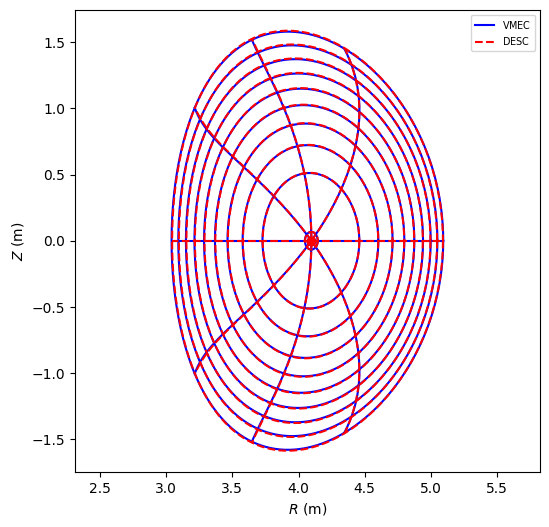

In [11]:
VMECIO.plot_vmec_comparison(eq2, "../../../tests/inputs/wout_solovev_freeb.nc");

We can plot the normal magnetic field error (the plotting function automatically will add the plasma current's contribution), and we can see that the normal field is very small for the final solution.

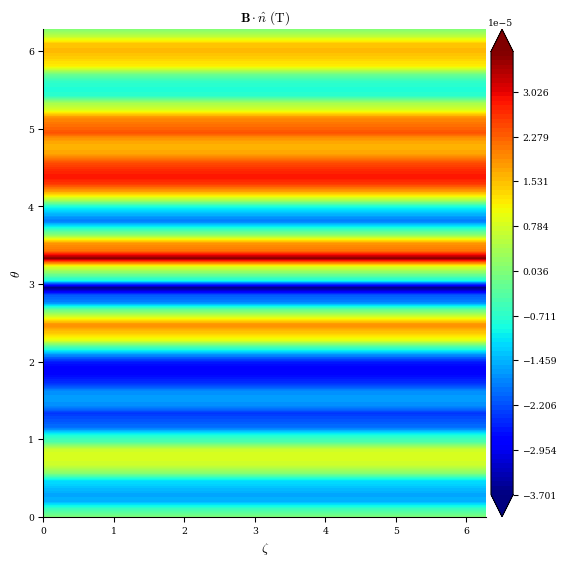

In [12]:
desc.plotting.plot_2d(eq2, "B*n", field=ext_field);

If a sheet current is known (or suspected) to exist on the plasma surface (such as if the pressure at the edge is nonzero), this can be modelled by making the equilibrium `surface` into a `FourierCurrentPotentialField`.

$\mu_0 \nabla \Phi = \mathbf{n} \times (\mathbf{B}_{out} - \mathbf{B}_{in})$

Where $\Phi$ is the current potential on the surface.


The current potential is represented as a `FourierCurrentPotentialField` which is a subclass of the standard `FourierRZToroidalSurface`. To include it as part of the free boundary calculation, we set the equilibrium surface to be an instance of `FourierCurrentPotentialField` by converting  the existing surface:

In [13]:
eq3 = eq2.copy()
eq3.surface = FourierCurrentPotentialField.from_surface(eq3.surface, M_Phi=4)

In [14]:
constraints = (
    ForceBalance(eq=eq3),
    FixIota(eq=eq3),
    FixPressure(eq=eq3),
    FixPsi(eq=eq3),
)
objective = ObjectiveFunction(BoundaryError(eq=eq3, field=ext_field, field_fixed=True))

In [15]:
R_modes = eq3.surface.R_basis.modes[np.max(np.abs(eq3.surface.R_basis.modes), 1) > 2, :]
Z_modes = eq3.surface.Z_basis.modes[np.max(np.abs(eq3.surface.Z_basis.modes), 1) > 2, :]
bdry_constraints = (
    FixBoundaryR(eq=eq3, modes=R_modes),
    FixBoundaryZ(eq=eq3, modes=Z_modes),
)
eq3, out = eq3.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,
    ftol=1e-4,
    # make the equilibrium solve subproblem ftol a bit lower, as we don't expect big changes in
    # the equilibrium, so we need to resolve the equilibrium more accurately to capture
    # the small changes we will see during this optimization
    options={"solve_options": {"ftol": 1e-4}},
)

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 420 ms
Timer: Objective build = 453 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 38.9 ms
Timer: Objective build = 50.7 ms
Timer: Objective build = 809 us
Timer: Eq Update LinearConstraintProjection build = 2.89 sec
Timer: Proximal projection build = 17.3 sec
Building objective: fixed iota
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 193 ms
Timer: LinearConstraintProjection build = 1.58 sec
Number of parameters: 11
Number of objectives: 123
Timer: Initializing the optimization = 19.1 sec

Starting optimization
Using method: proximal-lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method

If you would like to store the objective values before and after equilibrium solve, you can access them through `out`.

In [16]:
# info["Objective values"] is a dictionary of the objective values
for key in out["Objective values"].keys():
    if isinstance(out["Objective values"][key], dict):
        for subkey in out["Objective values"][key].keys():
            print(key, subkey, out["Objective values"][key][subkey])
    # if there are multiple instances of the same objective type,
    # there will be a list of dictionaries, each storing the values of the objective
    elif isinstance(out["Objective values"][key], list):
        for i in range(len(out["Objective values"][key])):
            for subkey in out["Objective values"][key][i].keys():
                print(key, subkey, out["Objective values"][key][i][subkey])

Total (sum of squares) f 4.864107276434656e-06
Total (sum of squares) f0 5.216459016961856e-06
Boundary Error:  Boundary normal field error:  {'f_max': Array(0.00011363, dtype=float64), 'f_min': Array(5.46424341e-08, dtype=float64), 'f_mean': Array(4.47664356e-05, dtype=float64), 'f_max_norm': Array(9.09288654e-05, dtype=float64), 'f_min_norm': Array(4.37243783e-08, dtype=float64), 'f_mean_norm': Array(3.58216943e-05, dtype=float64), 'f0_max': Array(0.00016989, dtype=float64), 'f0_min': Array(5.45234388e-08, dtype=float64), 'f0_mean': Array(7.63045645e-05, dtype=float64), 'f0_max_norm': Array(0.00013594, dtype=float64), 'f0_min_norm': Array(4.36291594e-08, dtype=float64), 'f0_mean_norm': Array(6.10582179e-05, dtype=float64)}
Boundary Error:  Boundary magnetic pressure error:  {'f_max': Array(0.00021837, dtype=float64), 'f_min': Array(9.08049005e-06, dtype=float64), 'f_mean': Array(0.00010881, dtype=float64), 'f_max_norm': Array(0.00071282, dtype=float64), 'f_min_norm': Array(2.964156e-

We can see that including the sheet current makes very little difference in the final result:

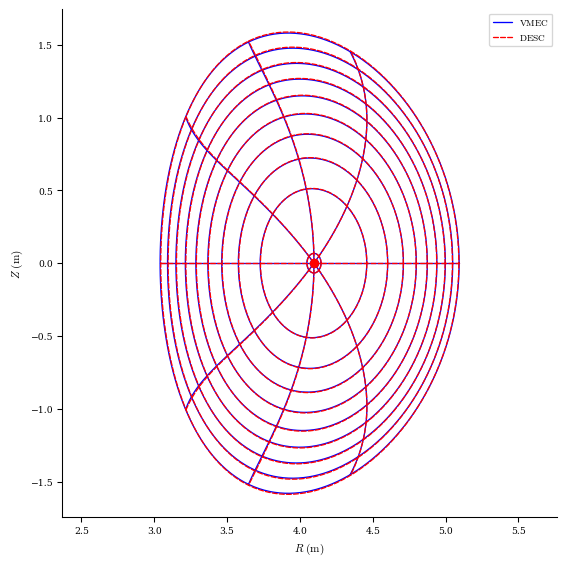

In [17]:
VMECIO.plot_vmec_comparison(eq3, "../../../tests/inputs/wout_solovev_freeb.nc");

We can see that the normal field error decreased slighlty, though not by much:

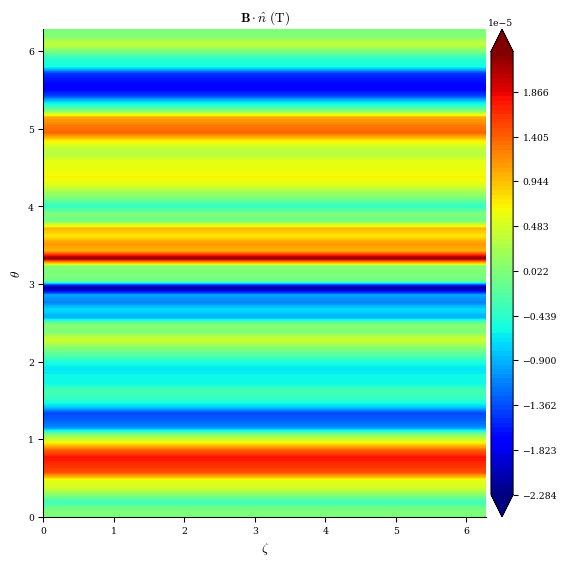

In [18]:
desc.plotting.plot_2d(eq3, "B*n", field=ext_field);

We can examine what the surface current looks like by plotting it below, and we see it is indeed quite small, only a few tens of Amps, compared to the plasma current which is ~1000x larger. In this case we could probably get equivalent results without including the sheet current term.

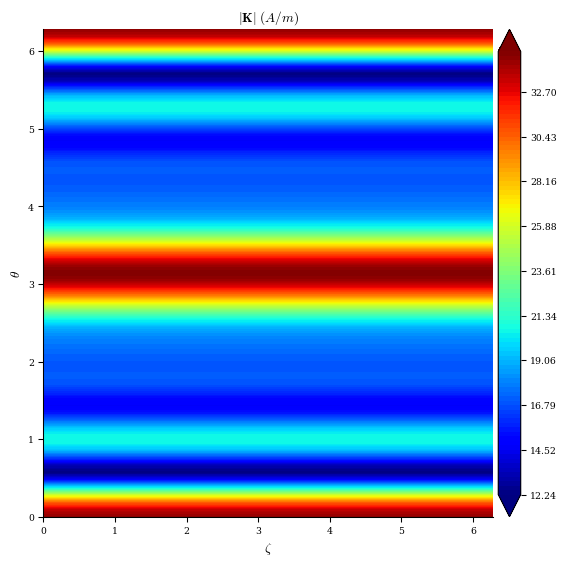

In [19]:
desc.plotting.plot_2d(eq3.surface, "K");

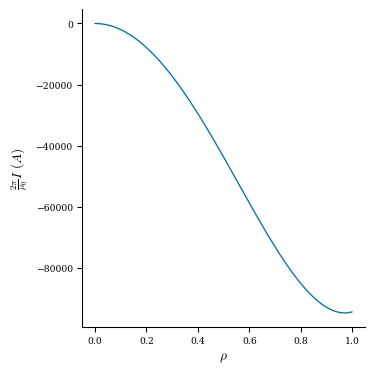

In [20]:
desc.plotting.plot_1d(eq3, "current");

## Vacuum Stellarator

We'll again use an mgrid file for our background field:

In [21]:
extcur = [4700.0, 1000.0]
ext_field = SplineMagneticField.from_mgrid(
    "../../../tests/inputs/mgrid_test.nc", extcur=extcur
)

For our initial guess, we'll again use a circular torus of approximately the right major and minor radius.

In [22]:
surf = FourierRZToroidalSurface(
    R_lmn=[0.70, 0.10],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-0.10],
    modes_Z=[[-1, 0]],
    NFP=5,
)

eq_init = Equilibrium(M=8, N=4, Psi=-0.035, surface=surf)
eq_init.solve();

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 452
Number of objectives: 2754

Starting optimization
Using method: lsq-exact
`gtol` condition satisfied. (gtol=1.00e-08)
         Current function value: 1.048e-13
         Total delta_x: 1.743e-01
         Iterations: 13
         Function evaluations: 20
         Jacobian evaluations: 14
                                                                 Start  -->   End
Total (sum of squares):                                      1.940e-02  -->   1.048e-13, 
Maximum absolute Force error:                                9.735e+03  -

In [23]:
eq2 = eq_init.copy()

And again we'll set up our constraints.

In [24]:
constraints = (
    ForceBalance(eq=eq2),
    FixCurrent(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

The `BoundaryError` objective we just used uses the virtual casing principle to compute the plasma component of the magnetic field, required to compute the boundary error. If we know we're solving a vacuum equilibrium, we can skip this calculating since we know the plasma component of the field is zero. This is done in the `VacuumBoundaryError` objective, which is much more efficient for vacuum equilibria.

In [25]:
objective = ObjectiveFunction(
    VacuumBoundaryError(eq=eq2, field=ext_field, field_fixed=True)
)

For the optimization, we'll do a "multigrid" approach where we first optimize the low order modes, and then the higher ones. For a simple problem like this it probably isn't necessary, but for higher resolution and more complicated shaping this is much more robust.

In [26]:
for k in [2, 4]:

    # get modes where |m|, |n| > k
    R_modes = eq2.surface.R_basis.modes[
        np.max(np.abs(eq2.surface.R_basis.modes), 1) > k, :
    ]
    Z_modes = eq2.surface.Z_basis.modes[
        np.max(np.abs(eq2.surface.Z_basis.modes), 1) > k, :
    ]

    # fix those modes
    bdry_constraints = (
        FixBoundaryR(eq=eq2, modes=R_modes),
        FixBoundaryZ(eq=eq2, modes=Z_modes),
    )
    # optimize
    eq2, out = eq2.optimize(
        objective,
        constraints + bdry_constraints,
        optimizer="proximal-lsq-exact",
        verbose=3,
        options={},
    )

Building objective: Vacuum boundary error
Precomputing transforms
Timer: Precomputing transforms = 742 ms
Timer: Objective build = 1.68 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 64.7 ms
Timer: Objective build = 82.2 ms
Timer: Objective build = 1.00 ms
Timer: Eq Update LinearConstraintProjection build = 137 ms
Timer: Proximal projection build = 4.21 sec
Building objective: fixed current
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 357 ms
Timer: LinearConstraintProjection build = 1.95 sec
Number of parameters: 25
Number of objectives: 1122
Timer: Initializing the optimization = 6.63 sec

Starting optimization
Using method: proximal-lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust R

And we see that the boundary has changed quite a lot:

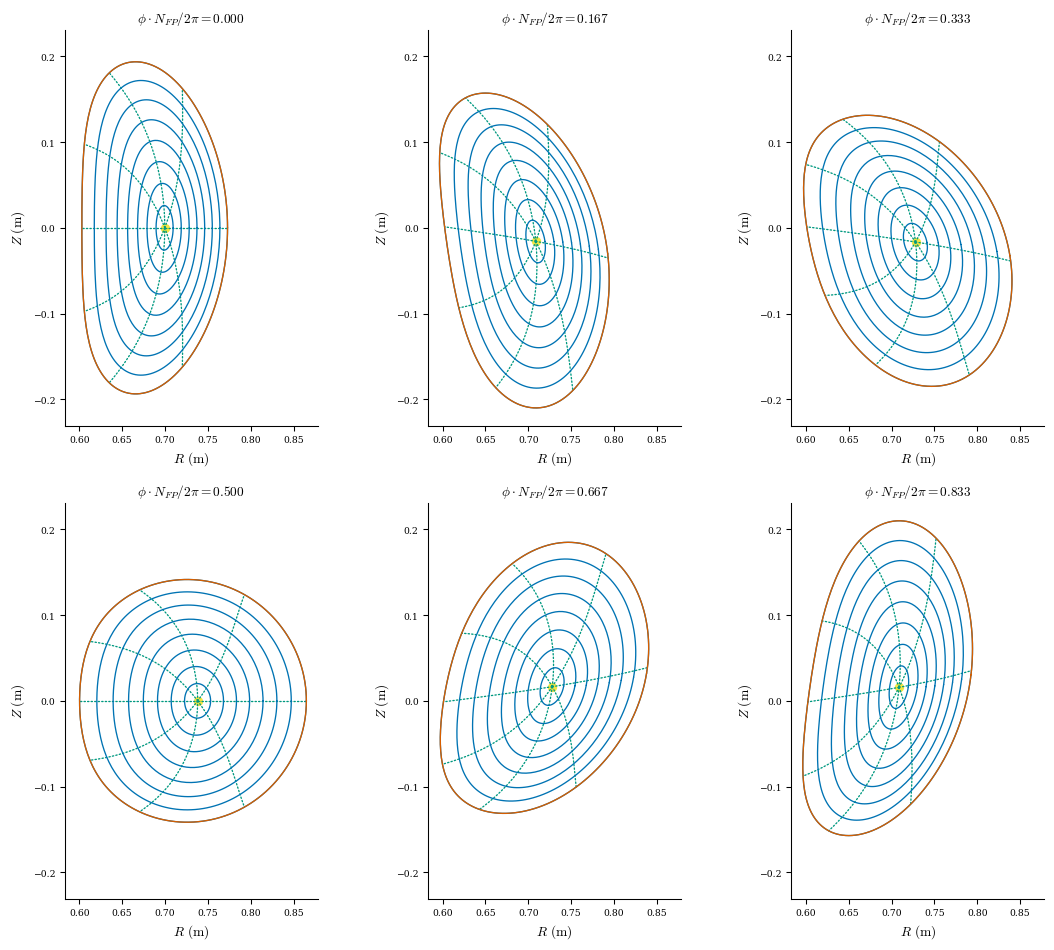

In [27]:
desc.plotting.plot_surfaces(eq2);

Because this is a vacuum equilibrium, we can verify the free boundary solution by tracing field lines directly from the external field. 

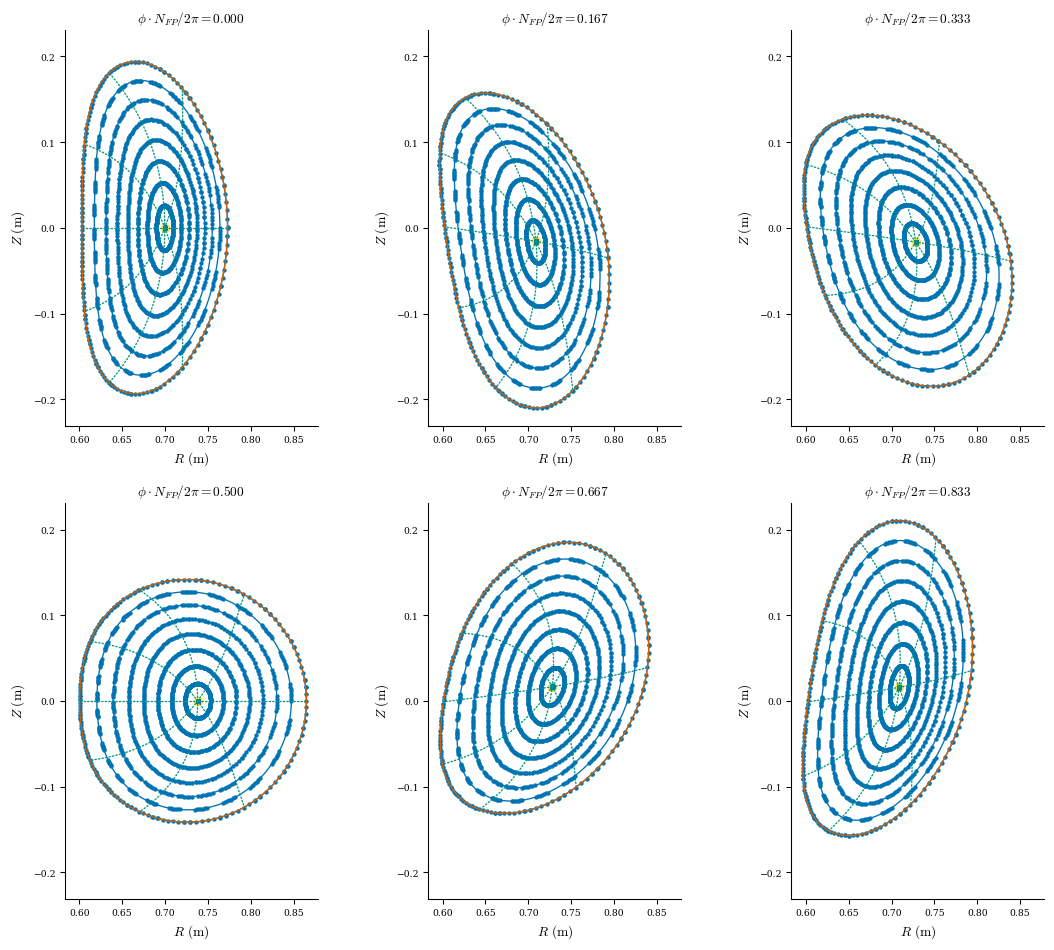

In [28]:
fig, ax = desc.plotting.plot_surfaces(eq2)

# for starting locations we'll pick positions on flux surfaces on the outboard midplane
grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
r0 = eq2.compute("R", grid=grid_trace)["R"]
z0 = eq2.compute("Z", grid=grid_trace)["Z"]

fig, ax = desc.plotting.poincare_plot(
    ext_field, r0, z0, ntransit=200, NFP=eq2.NFP, ax=ax
);

Note that while one can see a continuum of flux surfaces in the vacuum field, the one that the equilibrium free boundary solution will converge is determined by the value of ``eq2.Psi``, the net enclosed toroidal magnetic flux. For example, if we were to change ``eq2.Psi`` to a smaller value and run free-boundary, the new equilibrium's boundary would converge to an interior flux surface of the original, one corresponding to the smaller net enclosed toroidal flux. 